In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    log_loss,
    roc_auc_score,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
import numpy as np 
import pandas as pd 
from sklearn.model_selection import RandomizedSearchCV
import plotly
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from IPython.display import display, Image
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline,make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

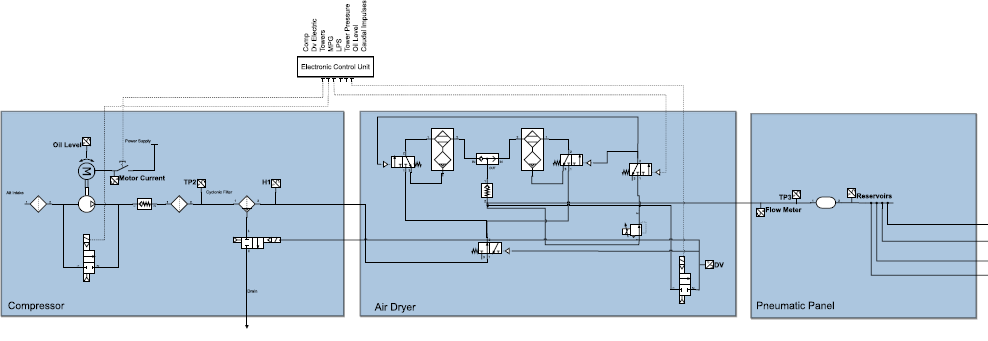

In [2]:
display(Image(filename="Esquema.png"))

### El conjunto de datos consta de 1.516.480 puntos de datos recopilados a 1 Hz de febrero a agosto de 2020 y se describe mediante 15 características de 7 sensores analógicos (1-7) y 8 digitales (8-15):

#### <u>APU</u>= Compresor
##### 1. <u>TP2 (bar)</u> : la medida de la presión en el compresor.
##### 2. <u>TP3 (bar):</u> la medida de la presión generada en el panel neumático.
##### 3. <u>H1 (bar):</u> la medida de la presión generada debido a la caída de presión cuando se descarga el separador ciclónico.
##### 4. <u>Presión DV (bar):</u> la medida de la caída de presión generada cuando las torres descargan los secadores de aire; una lectura 0 indica que el compresor está funcionando bajo carga.
##### 5. <u>Reservorios (bar):</u> la medida de la presión aguas abajo de los reservorios, que debe estar cerca de la presión del panel neumático (TP3).
##### 6. <u>Corriente del motor (A):</u> la medida de la corriente de una fase del motor trifásico; presenta valores cercanos a 0A - cuando se apaga, 4A - cuando funciona descargado, 7A - cuando trabaja bajo carga y 9A - cuando arranca.
##### 7. <u>Temperatura del aceite (ºC):</u> la medida de la temperatura del aceite en el compresor.
##### 8. <u>COMP:</u> La señal eléctrica de la válvula de entrada de aire en el compresor; está activo cuando no hay entrada de aire,
##### indicando que el compresor está apagado o funcionando en estado descargado.
##### 9. <u>DV eléctric:</u> la señal eléctrica que controla la válvula de salida del compresor; está activo cuando el compresor está
##### funcionando bajo carga e inactivo cuando el compresor está apagado o funcionando en estado descargado.
##### 10. <u>Torres:</u> La señal eléctrica que define la torre responsable de secar el aire y la torre responsable
##### para drenar la humedad extraída del aire; cuando no está activo indica que la torre uno está funcionando; cuando
##### activo, indica que la torre dos está en funcionamiento.
##### 11. <u>MPG:</u> la señal eléctrica responsable de arrancar el compresor bajo carga activando la válvula de admisión.
##### Cuando la presión en la unidad de producción de aire (APU) cae por debajo de 8,2 bar; activa el sensor COMP, que asume
##### el mismo comportamiento que el sensor MPG.
##### 12. <u>LPS:</u> la señal eléctrica que detecta y se activa cuando la presión cae por debajo de 7 bares.
##### 13. <u>Presostato:</u> la señal eléctrica que detecta la descarga en las torres de secado de aire.
##### 14. <u>Nivel de aceite:</u> la señal eléctrica que detecta el nivel de aceite en el compresor; está activo cuando el aceite está por debajo de valores esperados.
##### 15. <u>Pulsos de caudal:</u> la señal eléctrica que cuenta las salidas de pulso generadas por la cantidad absoluta de aire que fluye desde la APU a los reservorios.

### Definición de funciones

In [3]:
def violin_plot(variable_1,variable_2,Fecha_comienzo,Fecha_fin):

    Fecha_comienzo = Fecha_comienzo
    Fecha_fin= Fecha_fin
    df_filtrado = metro_df_grande[(metro_df_grande.timestamp>= Fecha_comienzo) & (metro_df_grande.timestamp<= Fecha_fin)]
    plt.figure(figsize=(4, 4))
    sns.violinplot(data=df_filtrado[[variable_1, variable_2]], palette='muted', split=True)

    # Añadir título y etiquetas a los ejes
    plt.title('Comparación de Variables con Violin Plot')
    plt.xlabel('Variable')
    plt.ylabel('Valor (bar)')

    # Mostrar el gráfico
    plt.show()
    return

In [105]:
df_sin_fallas[variable]

NameError: name 'variable' is not defined

In [3]:
def comparacion_medias(variable):
    print(f'Media de {variable} en condiciones normales = {round(df_sin_fallas[variable].mean(), 2)}')
    print(f'Media de {variable} en la semana previa a las falla = {round(df_con_fallas[variable].mean(), 2)}')
    
    return

In [4]:
def comparacion_ratios(variable):
    print(f'Ratio positivo de {variable} condiciones normales = {round(df_sin_fallas[variable].value_counts()[1]/df_sin_fallas[variable].value_counts()[0],2)}')
    print(f'Ratio positivo de {variable} semana previa a las fallas = {round(df_con_fallas[variable].value_counts()[1]/df_con_fallas[variable].value_counts()[0],2)}')
    return

In [5]:
def agregar_media_acumulada(df,nombre_variable_nueva,variable_acumulativa):
    df[nombre_variable_nueva]=df[variable_acumulativa].expanding().mean()
    return

In [6]:
def agregar_diferencia_media_acumulada(df,nombre_variable_nueva,variable_acumulativa_1,variable_acumulativa_2,variable_diferencia):
    df[variable_diferencia]=df[variable_acumulativa_1]-df[variable_acumulativa_2]
    df[nombre_variable_nueva]=df[nombre_variable_nueva&'dif'].expanding().mean()
    return

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [8]:
def numerical_columns_pipe(numerical_columns_list):
    numerical_pipe=make_pipeline(ColumnSelector(numerical_columns_list),StandardScaler())
    return numerical_pipe

def categorical_columns_pipe(categorical_columns_list):
    categorical_pipe= make_pipeline(ColumnSelector(categorical_columns_list))
    return categorical_pipe


### Limpieza y exploración de datos

In [9]:
metro_df_grande=pd.read_csv("MetroPT3.csv",sep=",")
metro_df_grande.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [10]:
metro_df_grande.drop(columns="Unnamed: 0",inplace=True)

In [11]:
metro_df_grande['timestamp'] = pd.to_datetime(metro_df_grande['timestamp']).dt.floor('D')

In [12]:
metro_df_grande.shape

(1516948, 16)

### Importamos el archivo de fallas, de acá va a salir nuestra variable objetivo, que es realizar una predicción de la falla por pérdida de aire.

In [13]:
fallas=pd.read_csv("Fallas.csv",sep=",")
fallas

,Failure Number,Start Time,End Time,Failure Type,Severity,Report
0,1,4/18/2020 0:00,4/18/2020 23:59,Air leak,High Stress,NaN
1,2,5/29/2020 23:30,5/30/2020 6:00,Air leak,High Stress,Maintenance on 4/30/2020 12:00
2,3,6/05/2020 10:00,6/07/2020 14:30,Air leak,High Stress,Maintenance on 6/08/2020 16:00
3,4,7/15/2020 14:30,7/15/2020 19:00,Air leak,High Stress,Maintenance on 7/16/2020 00:00


### Quitamos las horas de la variable start time, para simplificar la lectura.

In [14]:
fallas['Start Time'] = pd.to_datetime(fallas['Start Time']).dt.floor('D')


### Generamos un dataframe con los días anteriores a cada una de las 4 fallas

In [15]:
fallas_dia_anterior = pd.DataFrame(fallas['Start Time'])
fallas_dia_anterior['Fallas_dia_anterior']=fallas_dia_anterior['Start Time'] - timedelta(days=1)
fallas_dia_anterior.drop(columns="Start Time",inplace=True)
fallas_dia_anterior

,Fallas_dia_anterior
0,2020-04-17
1,2020-05-28
2,2020-06-04
3,2020-07-14


### Generamos un dataframe con los días anteriores a la detección de la falla. Se toman 7 dias hacia atras.

In [16]:
# Iteramos sobre cada fecha del DataFrame original
fechas_expandidas = []
for fecha in fallas['Start Time']:
    # Generamos un rango de fechas desde la fecha hasta 7 días antes
    rango_fechas = pd.date_range(end=fecha-timedelta(days=1), periods=7, freq='D')
    # Agregamos estas fechas al listado de fechas expandidas
    fechas_expandidas.extend(rango_fechas)

# Creamos un nuevo DataFrame con las fechas expandidas
fallas_semana_anterior = pd.DataFrame({'Fallas_semana_anterior': fechas_expandidas})
fallas_semana_anterior

,Fallas_semana_anterior
0,2020-04-11
1,2020-04-12
2,2020-04-13
3,2020-04-14
4,2020-04-15
5,2020-04-16
6,2020-04-17
7,2020-05-22
8,2020-05-23
9,2020-05-24


### Unimos el dataset con los dos dataframes creados con las fechas anteriories a la falla, de manera que tenemos una columna que se "enciende" para todos los registros del dia antes y otra que se enciende para todos los registros de hasta una semana anterior.

In [17]:
merged_df = pd.merge_asof(metro_df_grande, fallas_dia_anterior, left_on='timestamp', right_on='Fallas_dia_anterior',tolerance=pd.Timedelta(hours=6))
merged_df = pd.merge_asof(merged_df, fallas_semana_anterior, left_on='timestamp', right_on='Fallas_semana_anterior',tolerance=pd.Timedelta(hours=6))


In [18]:
merged_df["Fallas_dia_anterior"].value_counts()

2020-06-04    8716
2020-05-28    8436
2020-04-17    6301
2020-07-14    3563
Name: Fallas_dia_anterior, dtype: int64

In [19]:
merged_df["Fallas_semana_anterior"].value_counts()

2020-06-04    8716
2020-05-30    8617
2020-06-01    8523
2020-05-23    8458
2020-05-28    8436
2020-04-15    8433
2020-04-16    8027
2020-06-03    7976
2020-07-09    7518
2020-05-29    7466
2020-07-13    7434
2020-05-31    7294
2020-05-22    7233
2020-04-11    7229
2020-07-10    7157
2020-04-12    7125
2020-05-27    7096
2020-05-25    6902
2020-04-14    6329
2020-04-17    6301
2020-07-12    5609
2020-05-26    5606
2020-07-11    5253
2020-06-02    5131
2020-07-14    3563
2020-04-13    3501
2020-07-08    3107
2020-05-24     210
Name: Fallas_semana_anterior, dtype: int64

### Transformamos ambas columnas en nuestras variables objetivos, con valores 1 y 0 como posibles. Lo que buscaremos predecir es si un registro indica que el equipo tiene  máximo 1 semana hasta averiarse.

In [20]:
merged_df['Fallas_dia_anterior'] = merged_df['Fallas_dia_anterior'].notnull().astype(int)

In [21]:
merged_df['Fallas_dia_anterior'].value_counts()

0    1489932
1      27016
Name: Fallas_dia_anterior, dtype: int64

In [22]:
merged_df['Fallas_semana_anterior'] = merged_df['Fallas_semana_anterior'].notnull().astype(int)


In [23]:
merged_df['Fallas_semana_anterior'].value_counts()

0    1332698
1     184250
Name: Fallas_semana_anterior, dtype: int64

In [101]:
merged_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,...,Oil_level,Caudal_impulses,Fallas_dia_anterior,Fallas_semana_anterior,Promedio_acumulado_oil_temp,Promedio_acumulado_motor_current,panel_reservoir_dif,TP2_H1_dif,promedio_acum_pnl_res_dif,promedio_acum_TP2_H1_dif
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,...,1.0,1.0,0,0,53.6000,0.040000,0.0,-9.352,0.0,-9.352
2020-02-01,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,...,1.0,1.0,0,0,53.6375,0.040000,0.0,-9.346,0.0,-9.349
2020-02-01,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,...,1.0,1.0,0,0,53.6250,0.040833,0.0,-9.334,0.0,-9.344
2020-02-01,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,...,1.0,1.0,0,0,53.5750,0.040625,0.0,-9.324,0.0,-9.339
2020-02-01,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,...,1.0,1.0,0,0,53.5550,0.040500,0.0,-9.314,0.0,-9.334


### Generamos un dataframe en condiciones normales y con fallas para ver las diferencias

In [24]:
sin_fallas_mask = merged_df['Fallas_semana_anterior'] == 0
df_sin_fallas = merged_df[sin_fallas_mask]

In [25]:
df_con_fallas = merged_df[~sin_fallas_mask]


### Seteamos timestamp como indice, para que no altere los cálculos en los modelos.

In [26]:
merged_df.set_index("timestamp",inplace=True)
merged_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,Fallas_dia_anterior,Fallas_semana_anterior
timestamp,,,,,,,,,,,,,,,,,
2020-02-01,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0
2020-02-01,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0
2020-02-01,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0
2020-02-01,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0
2020-02-01,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0


### Análisis de variables


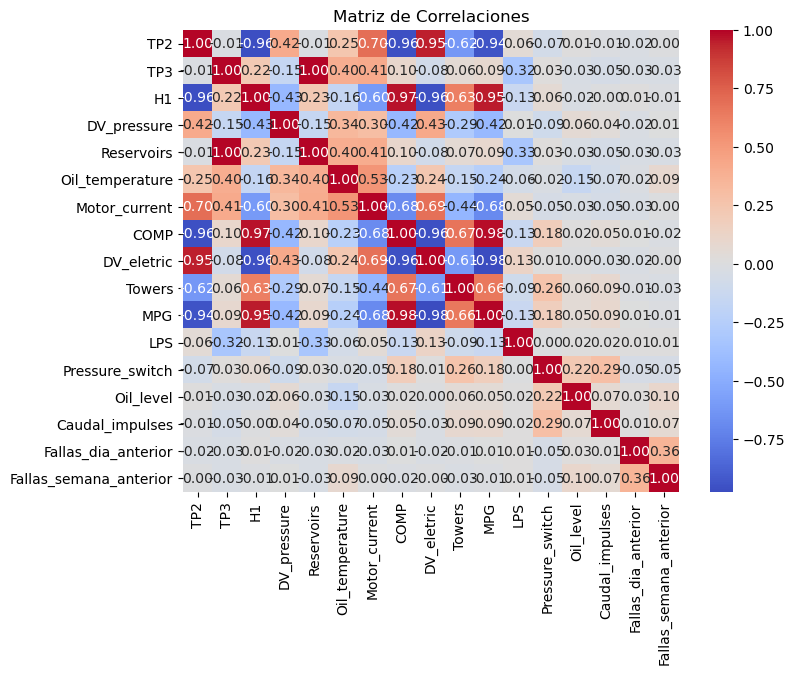

In [27]:
matriz_correlaciones = merged_df.corr()

# Creamos un heatmap utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlaciones')
plt.show()

#### Las variables <u>Reservoirs</u> y <u>Tp3</u> que representan las presiones en los tanques de almacenamiento y las presiones en el panel neumático respectivamente, tienen valores bastante similares. Dejamos ambas variables ya que luego incluiremos la diferencia entre ambas como nueva variable. Lo mismo sucede con <u>TP2</u> y <u>H1</u>, también presiones medidas en otros puntos y similares entre si. La variable <u>DV_pressure</u> no tiene relación con ninguna otra variable y no resulto influyente en el analisis posterior. La borramos para simplificar.

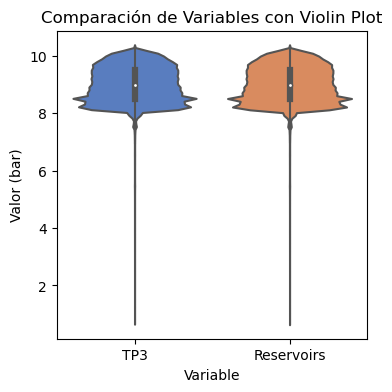

In [28]:
violin_plot("TP3","Reservoirs",'2020-03-01','2020-08-30')

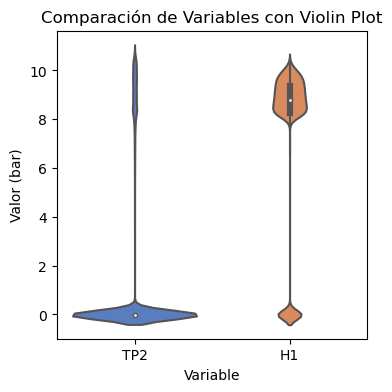

In [29]:
violin_plot("TP2","H1",'2020-02-01','2020-09-30')

### Las variables <u>COMP</u> y <u>MPG</u> son señales que funcionan de manera secuencial, una activa la otra. Por eso vemos sus valores iguales. Eliminamos <u>MPG</u> por ser redundante. <u>DV_electric</u> esta correlacionada negativamente con un coeficiciente similar a 1. La eliminamos también para evitar redundancia.

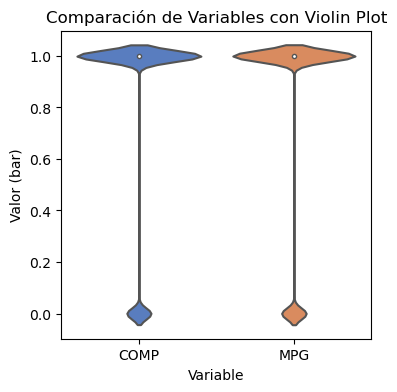

In [30]:
violin_plot("COMP","MPG",'2020-02-01','2020-09-30')

### Analizamos el promedio de las variables en la semana anterior a la falla vs condiciones normales

#### La temperatura del motor se eleva la semana previa a la falla. Es un buen predictor.

In [31]:
comparacion_medias('Oil_temperature')

Media de Oil_temperature en condiciones normales = 62.44
Media de Oil_temperature en la semana previa a las falla = 64.14


#### La corriente del motor parece aumentar levemente la semana previa a la falla.

In [32]:
comparacion_medias('Motor_current')

Media de Motor_current en condiciones normales = 2.05
Media de Motor_current en la semana previa a las falla = 2.07


#### La señal de oil_level se pone en 1 cuando el nivel de aceite es bajo, comparando los ratios de positividad vemos que la semana previa a la falla el ratio aumento considerablemente. Es una buena variable predictora.

In [33]:
comparacion_ratios('Oil_level')

Ratio positivo de Oil_level condiciones normales = 8.39
Ratio positivo de Oil_level semana previa a las fallas = 52.16


#### La señal de arranque del compresor se pone en 0 para indicar al compresor que abra la válvula de admisión. Si el ratio positivo disminuye las semanas previas a la falla, es porque el compresor tuvo mas señales de arranque para suplir posibles pérdidas de aire.

In [34]:
comparacion_ratios('COMP')

Ratio positivo de COMP condiciones normales = 5.21
Ratio positivo de COMP semana previa a las fallas = 4.61


#### La señal de LPS se activa cuando la presión baja de los 7 bares, una pérdida de aire puede aumentar el ratio positivo de este parametro. Se ve un leve aumento.

In [35]:
comparacion_ratios('LPS')

Ratio positivo de LPS condiciones normales = 0.0
Ratio positivo de LPS semana previa a las fallas = 0.01


#### La señal positiva nos indica un mayor funcionamiento de la torre de secado de aire número 2. El funcionamiento de este equipo no da evidencias de que pueda estar relacionado a la variable objetivo a simple vista. 

In [36]:
comparacion_ratios('Towers')

Ratio positivo de Towers condiciones normales = 11.89
Ratio positivo de Towers semana previa a las fallas = 9.14


#### El pressure_switch se enciende con la activación de los secadores. Un aumento de ratio positivo indica un mayor funcionamiento del compresor, lo cual puede estar ocurriendo para suplir una pérdida de aire.

In [37]:
comparacion_ratios('Pressure_switch')

Ratio positivo de Pressure_switch condiciones normales = 143.92
Ratio positivo de Pressure_switch semana previa a las fallas = 47.56


### El switch positivo de Caudal_impulses indica flujo de aire hacia los reservorios. Se observa un aumento de flujo de aire, lo que puede indicar mayor trabajo del compresor para suplir pérdidas.

In [38]:
comparacion_ratios('Caudal_impulses')

Ratio positivo de Caudal_impulses condiciones normales = 13.5
Ratio positivo de Caudal_impulses semana previa a las fallas = 52.16


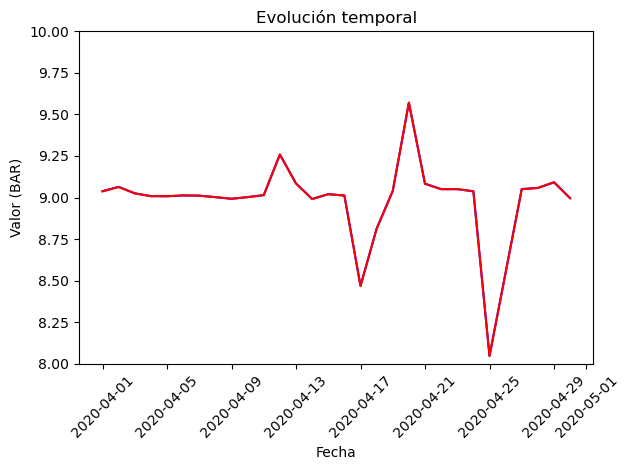

In [42]:
semana_fecha_comienzo_falla1 = '2020-04-01'
semana_fecha_fin_falla1= '2020-04-30'
df_filtrado = metro_df_grande[(metro_df_grande.timestamp>= semana_fecha_comienzo_falla1) & (metro_df_grande.timestamp<= semana_fecha_fin_falla1)]
promedio_diario = df_filtrado.groupby(df_filtrado['timestamp'].dt.date)['Reservoirs'].mean()
promedio_diario_df = promedio_diario.reset_index()
promedio_diario_df.columns = ['Fecha', 'Promedio']
# Crear el gráfico de líneas
promedio_diario_2 = df_filtrado.groupby(df_filtrado['timestamp'].dt.date)['TP3'].mean()
promedio_diario_df_2 = promedio_diario.reset_index()
promedio_diario_df_2.columns = ['Fecha', 'Promedio']


plt.plot(promedio_diario.index, promedio_diario, linestyle='-',color="b")
plt.plot(promedio_diario_2.index, promedio_diario_2, linestyle='-',color="r")
# Añadir título y etiquetas a los ejes
plt.title('Evolución temporal')
plt.xlabel('Fecha')
plt.ylabel('Valor (BAR)')
plt.ylim(8, 10)
# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el layout para que las etiquetas no se corten
plt.show()

### Agregamos los promedios acumulados como features para ver si tienen impacto en el resultado de la predicción.

In [39]:
agregar_media_acumulada(merged_df,"Promedio_acumulado_oil_temp","Oil_temperature")

In [40]:
agregar_media_acumulada(merged_df,"Promedio_acumulado_motor_current","Motor_current")

#### Hago lo mismo pero con las diferencias entre TP3 y Reservoirs, TP2 y H1.

In [41]:
merged_df['panel_reservoir_dif'] = merged_df['TP3'] - merged_df['Reservoirs']
merged_df['TP2_H1_dif'] = merged_df['TP2'] - merged_df['H1']

In [42]:
agregar_media_acumulada(merged_df,"promedio_acum_pnl_res_dif","panel_reservoir_dif")
agregar_media_acumulada(merged_df,"promedio_acum_TP2_H1_dif","TP2_H1_dif")

### Separamos en X, y, Train y Test. <u>La variable objetivo se "enciende"</u> cuando el registro cae hasta 7 días antes de cualquiera de las 4 fallas.

In [43]:
X = merged_df[["Caudal_impulses",'Pressure_switch','COMP','TP3','Reservoirs','LPS','Oil_level','Oil_temperature','Promedio_acumulado_oil_temp','promedio_acum_pnl_res_dif','Promedio_acumulado_motor_current',"promedio_acum_TP2_H1_dif"]]

y = merged_df.Fallas_semana_anterior

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [45]:
numerical_pipe=numerical_columns_pipe(['TP3', 'Reservoirs','Oil_temperature', 'Promedio_acumulado_oil_temp',
       'promedio_acum_pnl_res_dif', 'Promedio_acumulado_motor_current','promedio_acum_TP2_H1_dif'])
categorical_pipe=categorical_columns_pipe(['Caudal_impulses', 'Pressure_switch', 'COMP', 'Oil_level'])


In [95]:
def modelo_ensamble_sin_optimizacion(X_train,X_test,y_train,y_test,descripcion_modelo,modelo,numerical_pipe,categorical_pipe):
    union = make_union(numerical_pipe,
                   categorical_pipe)
    pipeline = Pipeline([('union', union), 
                     (descripcion_modelo,modelo)])
    
    
    
    pipeline.fit(X_train,y_train)
    y_pred= pipeline.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred )
    cr=classification_report(y_test, y_pred)
    
    y_pred_proba = pipeline.predict_proba(X_test)
    print(cr)
    print("Matriz de Confusión: ")
    print(cm)
    print("Accuracy= ", accuracy_score(y_test, y_pred))
    
    return pipeline,y_pred

    

In [83]:
def modelo_ensamble(X_train,X_test,y_train,y_test,descripcion_modelo,modelo,numerical_pipe,categorical_pipe,params):
    union = make_union(numerical_pipe,
                   categorical_pipe)
    pipeline = Pipeline([('union', union), 
                     (descripcion_modelo,modelo)])
    
    folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    randomized= RandomizedSearchCV(modelo,param_distributions=params, cv=folds, verbose=1, n_jobs=-1,n_iter=3)
    
    randomized.fit(X_train,y_train)
    y_pred = randomized.best_estimator_.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred )
    cr=classification_report(y_test, y_pred)
    
    print("Best score: %0.3f" % randomized.best_score_) 
    print("Best parameters set:" )
    best_parameters = randomized.best_estimator_.get_params()
    for param_name in sorted (params.keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 
      
    
    print(cr)
    print("Matriz de Confusión: ")
    print(cm)
    print("Accuracy= ", accuracy_score(y_test, y_pred))
    
    return randomized.best_estimator_


### Testeamos con el modelo de regresión logística

In [104]:
y_test

timestamp
2020-03-31    0
2020-04-15    1
2020-03-18    0
2020-05-30    1
2020-06-19    0
             ..
2020-03-29    0
2020-03-10    0
2020-02-26    0
2020-05-22    1
2020-02-21    0
Name: Fallas_semana_anterior, Length: 303390, dtype: int32

In [57]:
modelo_ensamble(X_train,X_test,y_train,y_test,"lr",LogisticRegression(),numerical_pipe,categorical_pipe)

C:\Users\manue\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.88      1.00      0.93    266510
           1       0.12      0.00      0.00     36880

    accuracy                           0.88    303390
   macro avg       0.50      0.50      0.47    303390
weighted avg       0.79      0.88      0.82    303390

Accuracy=  0.8764131975345265


(array([[265803,    707],
        [ 36788,     92]], dtype=int64),
 None,
 None)

### Testeamos con el modelo de KNN, optimizando hiperparametros con RandomizedSearch

In [49]:
params={'n_neighbors': range(1,30),
     'weights' : ['uniform', 'distance'],
     'p' : [1, 2, 3]}
modelo_ensamble(X_train,X_test,y_train,y_test,"knn",KNeighborsClassifier(),numerical_pipe,categorical_pipe,params)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.987
Best parameters set:
	 n_neighbors: 3
	 p: 2
	 weights: 'distance'
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    266620
           1       0.95      0.95      0.95     36770

    accuracy                           0.99    303390
   macro avg       0.97      0.97      0.97    303390
weighted avg       0.99      0.99      0.99    303390

[[264795   1825]
 [  1805  34965]]
Accuracy=  0.9880352022149709


(None, None, None)

### Testeamos con el modelo de XGB

In [56]:
params = {  
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
}

In [57]:
modelo_ensamble(X_train,X_test,y_train,y_test,"xgb",XGBClassifier(n_jobs=-1, use_label_encoder=False,n_estimators=10),numerical_pipe,categorical_pipe,params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 1.000
Best parameters set:
	 learning_rate: 0.1
	 max_depth: 3
	 n_estimators: 500
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266620
           1       1.00      1.00      1.00     36770

    accuracy                           1.00    303390
   macro avg       1.00      1.00      1.00    303390
weighted avg       1.00      1.00      1.00    303390

[[266541     79]
 [    31  36739]]
Accuracy=  0.9996374303701506


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

### Testeamos con el modelo de LightGBM

In [72]:
params = {  
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
}

In [76]:
pipeline_entrenado=modelo_ensamble_sin_optimizacion(X_train,X_test,y_train,y_test,"lgb",lgb.LGBMClassifier(),numerical_pipe,categorical_pipe)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266620
           1       1.00      1.00      1.00     36770

    accuracy                           1.00    303390
   macro avg       1.00      1.00      1.00    303390
weighted avg       1.00      1.00      1.00    303390

[[266565     55]
 [    41  36729]]
Accuracy=  0.9996835755957678


### Testeamos con el modelo de CatBoost Classifier

In [81]:
pipeline_entrenado_CBT=modelo_ensamble_sin_optimizacion(X_train,X_test,y_train,y_test,"ctb", CatBoostClassifier(iterations=100, 
                           od_type='IncToDec', 
                           od_wait=20, 
                           random_seed=42, 
                           eval_metric='Accuracy', 
                           logging_level='Silent'),numerical_pipe,categorical_pipe)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266620
           1       1.00      1.00      1.00     36770

    accuracy                           1.00    303390
   macro avg       1.00      1.00      1.00    303390
weighted avg       1.00      1.00      1.00    303390

[[266588     32]
 [    28  36742]]
Accuracy=  0.9998022347473549


### Probamos con el modelo de GradientBoosting Classifier

In [96]:
pipeline_entrenado_GBC,y_pred=modelo_ensamble_sin_optimizacion(X_train,X_test,y_train,y_test,"gtb", GradientBoostingClassifier(loss = 'log_loss',
                                           learning_rate=0.6,
                                           n_estimators = 20,
                                           subsample=1,
                                           criterion='squared_error',
                                           random_state = 127),numerical_pipe,categorical_pipe)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266620
           1       1.00      1.00      1.00     36770

    accuracy                           1.00    303390
   macro avg       1.00      1.00      1.00    303390
weighted avg       1.00      1.00      1.00    303390

Matriz de Confusión: 
[[266615      5]
 [     8  36762]]
Accuracy=  0.9999571508619269


In [99]:
y_test

timestamp
2020-03-31    0
2020-04-15    1
2020-03-18    0
2020-05-30    1
2020-06-19    0
             ..
2020-03-29    0
2020-03-10    0
2020-02-26    0
2020-05-22    1
2020-02-21    0
Name: Fallas_semana_anterior, Length: 303390, dtype: int32

In [98]:
y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [90]:
pipeline_entrenado_GBC.named_steps["gtb"]

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,
                           n_estimators=20, random_state=127, subsample=1)

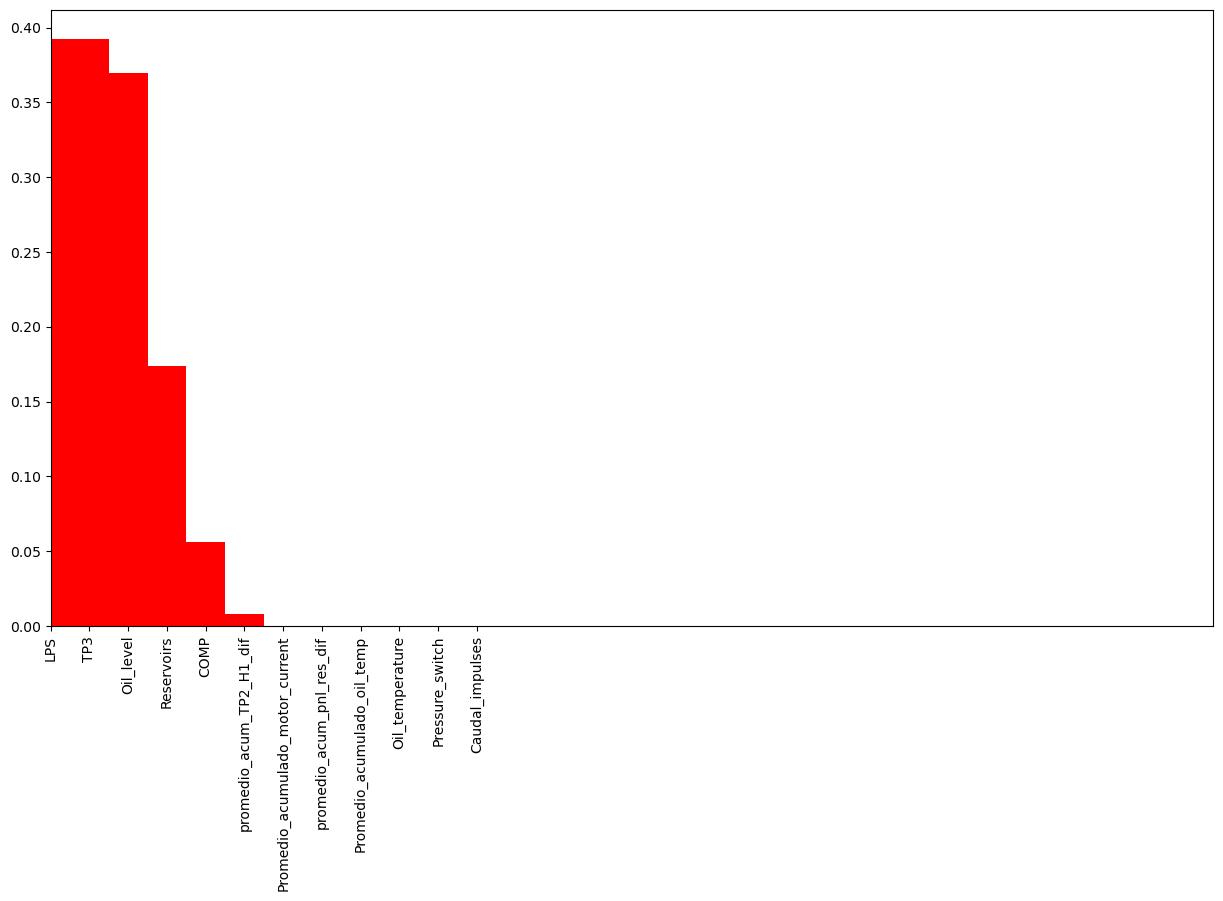

In [94]:

modelo_entrenado = pipeline_entrenado_GBC.named_steps["gtb"]
y=np.sort(modelo_entrenado.feature_importances_)
x=np.argsort(modelo_entrenado.feature_importances_)
x=x[::-1]
feat_names=X_train.columns
labels=feat_names[x]
y=y[::-1]

plt.figure(figsize=(15,8))
plt.bar(range(len(y)),y,color = "r",width=3,align = "center")
plt.xticks(range(len(y)), labels, rotation=90)

plt.xlim([0,30])
plt.show()